In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Load the encoded protein sequences, labels and masks

In [7]:
# The masks are not needed for the FFN or CNN models
train = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']
#print(X_val.shape)

### Building the network by defining the network architecture.
We have an input layer, dense layer and output layer.

In [8]:
# Set the hyperparameters of the network:
batch_size = 128
seq_len = 400
n_feat = 20
n_hid = 30
n_class = 10
lr = 0.0025
drop_prob = 0.5

Define the layers of the network

In [9]:
input_shape = (seq_len, n_feat)
model = Sequential()
# Input layer, holds the shape of the data, flattening the input
model.add(Flatten(input_shape=input_shape))
# Dense layer with ReLu activation function
model.add(Dense(units=n_hid, activation='relu'))
model.add(Dropout(drop_prob))
# Output layer with a Softmax activation function
model.add(Dense(units=n_class, activation='softmax'))

### Calculate the prediction and network loss for the training set and update the network weights:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                240030    
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 240,340
Trainable params: 240,340
Non-trainable params: 0
_________________________________________________________________
None


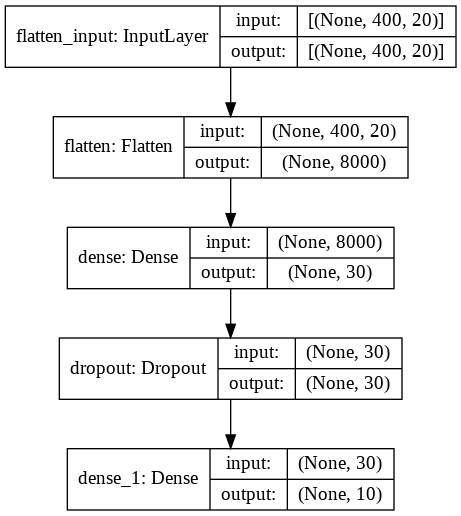

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])
# todo weights normalization?
print(model.summary())
plot_model(model, "model.png", show_shapes=True)

### Train


In [11]:
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

# Number of epochs
num_epochs = 80
checkpoint = ModelCheckpoint(filepath='/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/FFN_weights.hdf5',
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

# Calculate also the prediction and network loss for the validation set:
history = model.fit(X_train, y_train, epochs=80, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint])

Epoch 1/80
19/19 [==============================] - 3s 15ms/step - loss: 2.1265 - accuracy: 0.2448 - val_loss: 1.6684 - val_accuracy: 0.4331

Epoch 00001: val_loss improved from inf to 1.66837, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/FFN_weights.hdf5
Epoch 2/80
19/19 [==============================] - 0s 7ms/step - loss: 1.5674 - accuracy: 0.4742 - val_loss: 1.3524 - val_accuracy: 0.6236

Epoch 00002: val_loss improved from 1.66837 to 1.35239, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/FFN_weights.hdf5
Epoch 3/80
19/19 [==============================] - 0s 7ms/step - loss: 1.1896 - accuracy: 0.6440 - val_loss: 1.1792 - val_accuracy: 0.6630

Epoch 00003: val_loss improved from 1.35239 to 1.17920, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/FFN_weights.hdf5
Epoch 4/80
19/19 [==============================] - 0s 6ms/step - loss: 0.9849 - accuracy: 0.7015 - val_lo

In [ ]:
print("Minimum validation loss: {:.6f}".format(min(history.history['val_loss'])))
acc_index = np.argmin(history.history['val_loss'])
print("With accuracy: {:.6f}".format(history.history['val_accuracy'][acc_index]))

In [12]:
### Model loss and accuracy

Plots of loss and accuracy for training and validation set at each epoch.



Minimum validation loss: 0.804492
With accuracy: 0.749606


### Model loss and accuracy

Plots of loss and accuracy for training and validation set at each epoch.



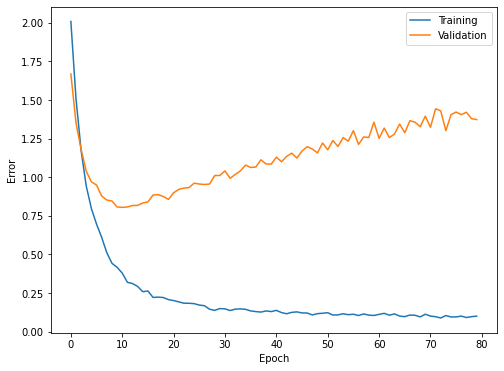

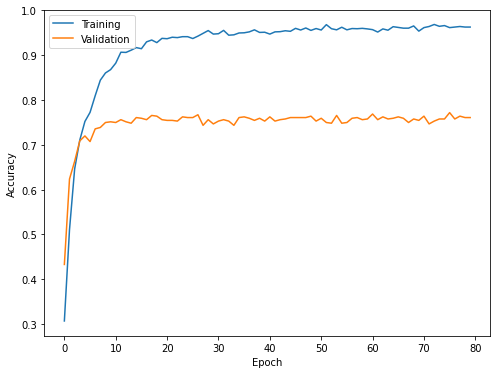

In [13]:
x_axis = range(num_epochs)
plt.figure(figsize=(8, 6))
# loss_training:
plt.plot(x_axis, history.history['loss'])
# loss_validation
plt.plot(x_axis, history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training', 'Validation'))
plt.show()

plt.figure(figsize=(8, 6))
# accuracy training
plt.plot(x_axis, history.history['accuracy'])
# accuracy validation
plt.plot(x_axis, history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training', 'Validation'))
plt.show()


### Confusion matrix
The confusion matrix shows how well is predicted each class and which are the most common mis-classifications.

Code based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


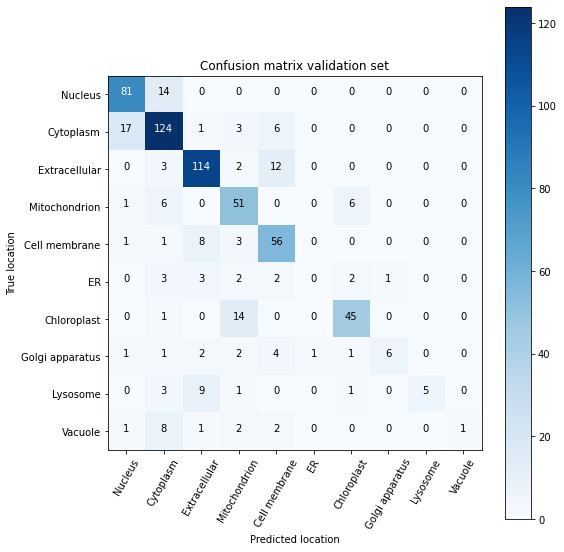

In [14]:
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

confusion_mat = confusion_matrix(validation['y_val'], y_pred)

plt.figure(figsize=(8, 8))
colormap = plt.cm.Blues
plt.imshow(confusion_mat, interpolation='nearest', cmap=colormap)
plt.title('Confusion matrix validation set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus', 'Cytoplasm', 'Extracellular', 'Mitochondrion', 'Cell membrane', 'ER', 'Chloroplast',
                'Golgi apparatus', 'Lysosome', 'Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = confusion_mat.max() / 2.0
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, confusion_mat[i, j],
             horizontalalignment="center",
             color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location')
plt.show()